## A visual exploration of TfL Data
#### Becoming a Data Scientist Learning Club - Activity 2

Some resources I used:
* [Seaborn](http://stanford.edu/~mwaskom/software/seaborn/)
* [A blog post I found on visualising dates with matplotlib](http://blog.mafr.de/2012/03/11/time-series-data-with-matplotlib/)
* Stack Overflow (obviously)

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

plt.style.use('fivethirtyeight')
%matplotlib inline

In [87]:
df = pd.read_csv('tfl-journeys.csv')
# Housekeeping - rename columns
df.columns = ['PeriodFY', 'Period', 'DaysInPeriod', 'PeriodBeginning', 'PeriodEnding', 'Bus', 'Tube', 'DLR', 'Tram', 'Overground', 'EmiratesAirline']

/home/david/miniconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


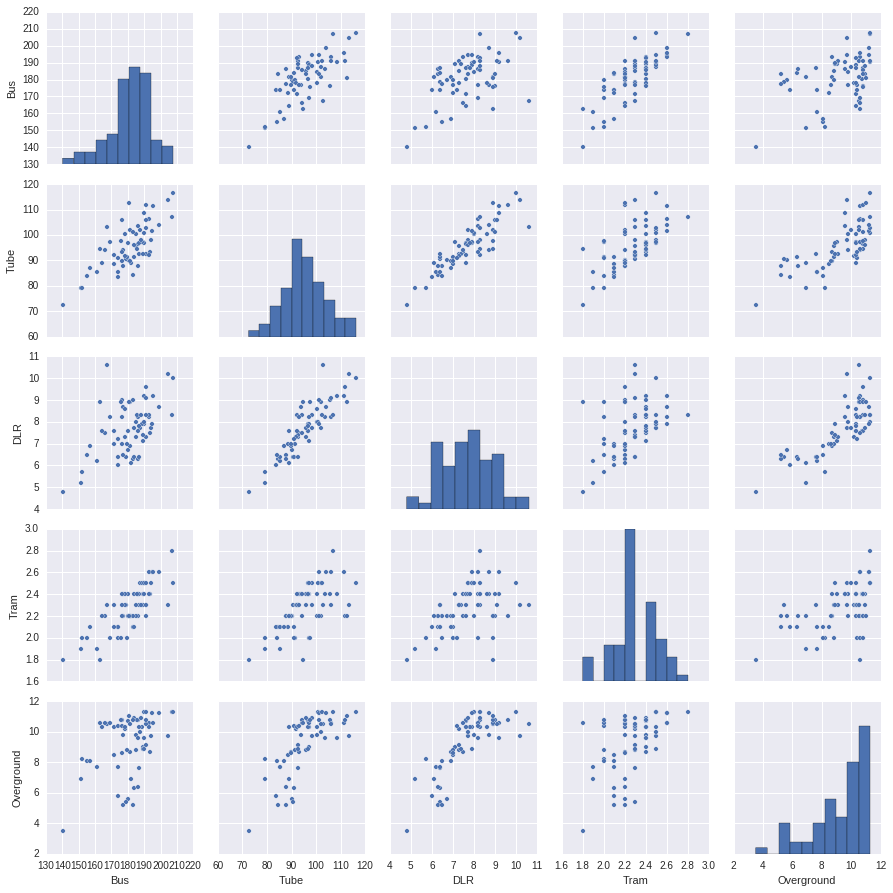

In [22]:
# try scatter matrix with all columns except the Emirates (as it has the most nulls)
sns.pairplot(df[['Bus', 'Tube', 'DLR', 'Tram', 'Overground']].dropna())

/home/david/miniconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


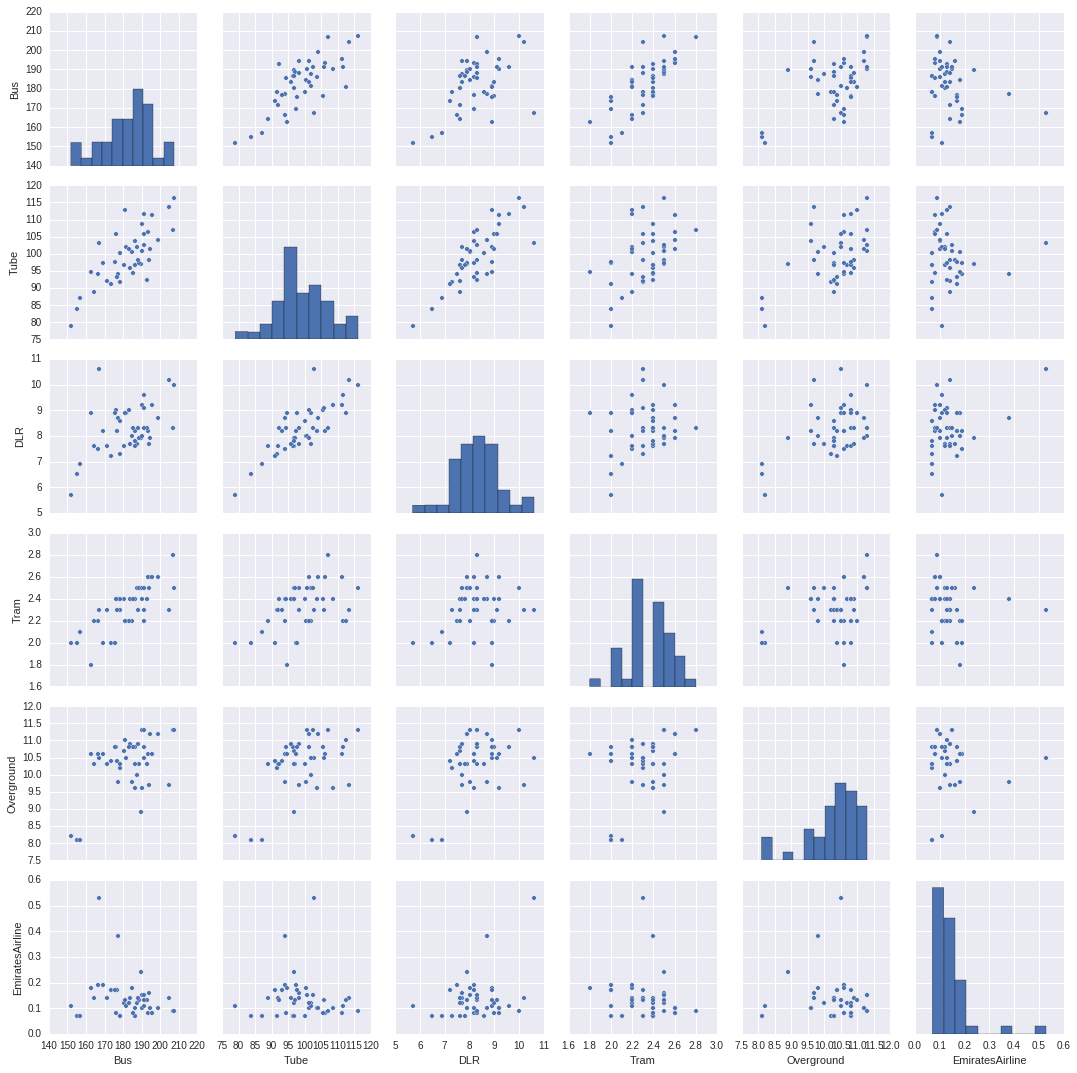

In [23]:
# let's try the same thing with the Emirates Airline
sns.pairplot(df[['Bus', 'Tube', 'DLR', 'Tram', 'Overground', 'EmiratesAirline']].dropna())

So it seems all types of public transport have linear relationships with each other; when more people take public transport, they take all the types more, **except for the Emirates Airline**. That's probably because people don't use that to commute, it's more for tourists, so we can expect different behaviour.

Most of the distributions are normal, but the Overground is heavily skewed to the left.

What about the types over time? What are the busier periods?

In [117]:
transport_data = df[['Bus', 'Tube', 'DLR', 'Tram', 'Overground', 'Period', 'PeriodBeginning']].dropna()
# convert string to matplotlib-friendly dates
transport_data['PeriodDate'] = transport_data['PeriodBeginning'].map(lambda x: mdates.datestr2num(x))

Let's plot TfL usage over time!

Colours taken from the official [**TfL colour standard**](http://content.tfl.gov.uk/tfl-colour-standard.pdf) (obviously)

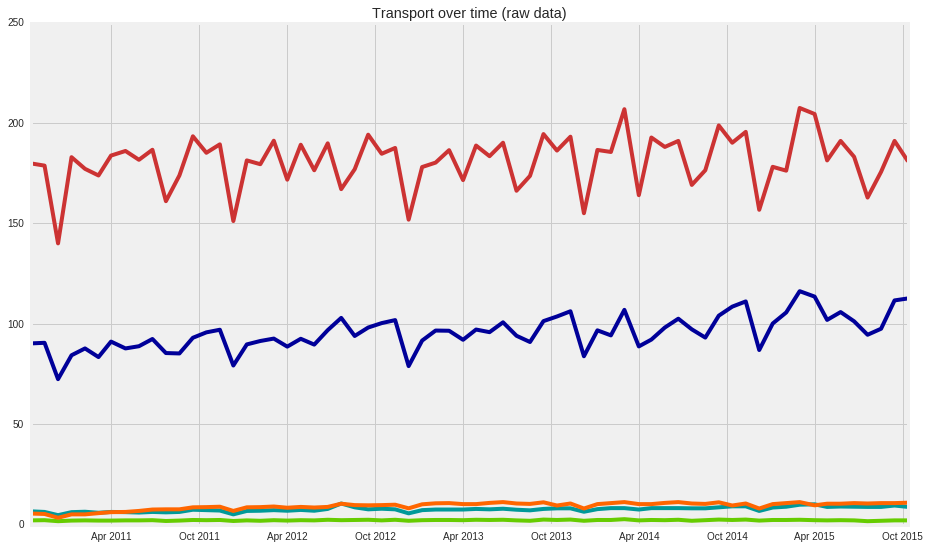

In [110]:
# time on x-axis, transport on y-axis
fig, ax = plt.subplots(figsize=(14,9))

ax.set_title('Transport over time (raw data)')
ax.plot_date(x=transport_data['PeriodDate'], y=transport_data['Bus'], fmt='-', color='#cc3333')
ax.plot_date(x=transport_data['PeriodDate'], y=transport_data['Tube'], fmt='-', color='#000099')
ax.plot_date(x=transport_data['PeriodDate'], y=transport_data['DLR'], fmt='-', color='#009999')
ax.plot_date(x=transport_data['PeriodDate'], y=transport_data['Tram'], fmt='-', color='#66CC00')
ax.plot_date(x=transport_data['PeriodDate'], y=transport_data['Overground'], fmt='-', color='#FF6600')

plt.show()

As the scatter matrix suggested, the figures seem to vary together over time.

It's hard to see due to scaling issues, so we could normalise each column to the unit interval to see if it reveals anything if we can directly superimpose the lines on top of each other.

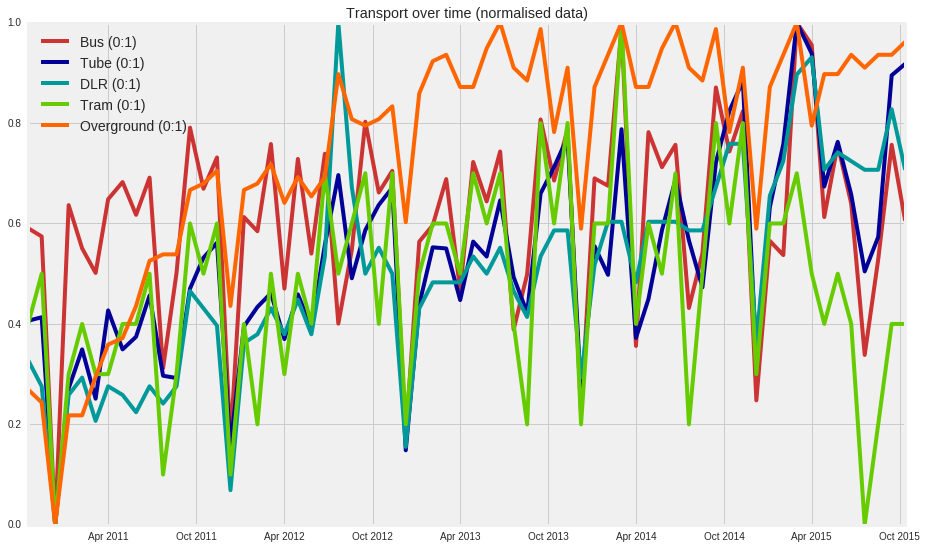

In [118]:
# normalise each variable to unit scale for better plotting
for i in range(5):
    col = transport_data.columns[i]
    transport_data[col + ' (0:1)'] = transport_data[col].apply(lambda x: (x - transport_data[col].min()) / (transport_data[col].max() - transport_data[col].min()))
fig, ax = plt.subplots(figsize=(14,9))

ax.set_title('Transport over time (normalised data)')
ax.plot_date(x=transport_data['PeriodDate'], y=transport_data['Bus (0:1)'], fmt='-', color='#cc3333')
ax.plot_date(x=transport_data['PeriodDate'], y=transport_data['Tube (0:1)'], fmt='-', color='#000099')
ax.plot_date(x=transport_data['PeriodDate'], y=transport_data['DLR (0:1)'], fmt='-', color='#009999')
ax.plot_date(x=transport_data['PeriodDate'], y=transport_data['Tram (0:1)'], fmt='-', color='#66CC00')
ax.plot_date(x=transport_data['PeriodDate'], y=transport_data['Overground (0:1)'], fmt='-', color='#FF6600')
ax.legend(loc=2, fontsize=14)
plt.show()

That's messy :-(

We can still see the columns varying together. What about busiest periods in a *bar chart*?

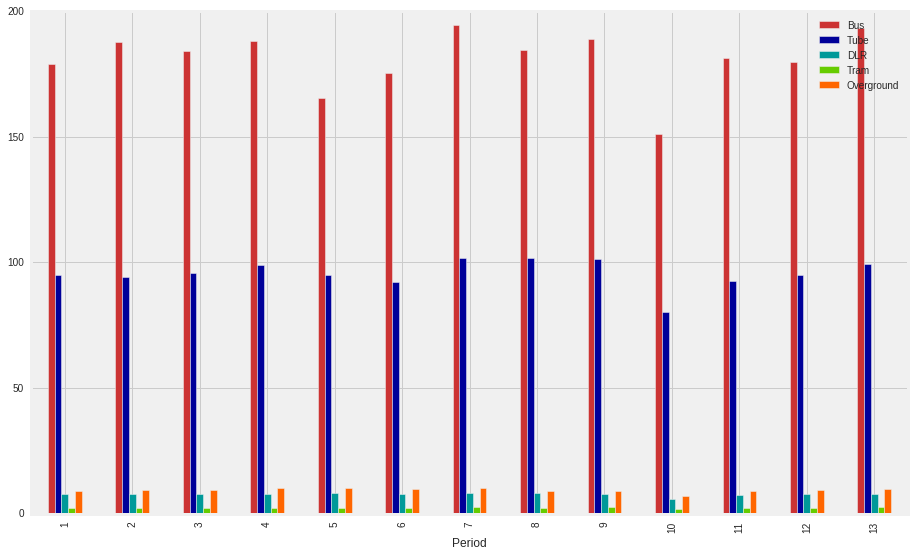

In [143]:
# group by period
transport_data['TotalTravel'] = transport_data['Bus'] + transport_data['Tube'] + transport_data['Overground'] + transport_data['DLR'] + transport_data['Tram']
periods = transport_data.groupby(by='Period')

fig, ax = plt.subplots(figsize=(14,9))
# plot mean of each transport per period
periods.mean()[['Bus','Tube', 'DLR', 'Tram', 'Overground']].plot(kind='bar', color=['#cc3333', '#000099', '#009999', '#66CC00', '#FF6600'], ax=ax)
plt.show()

Stacked bar charts don't work well with different scales. How about normalised?

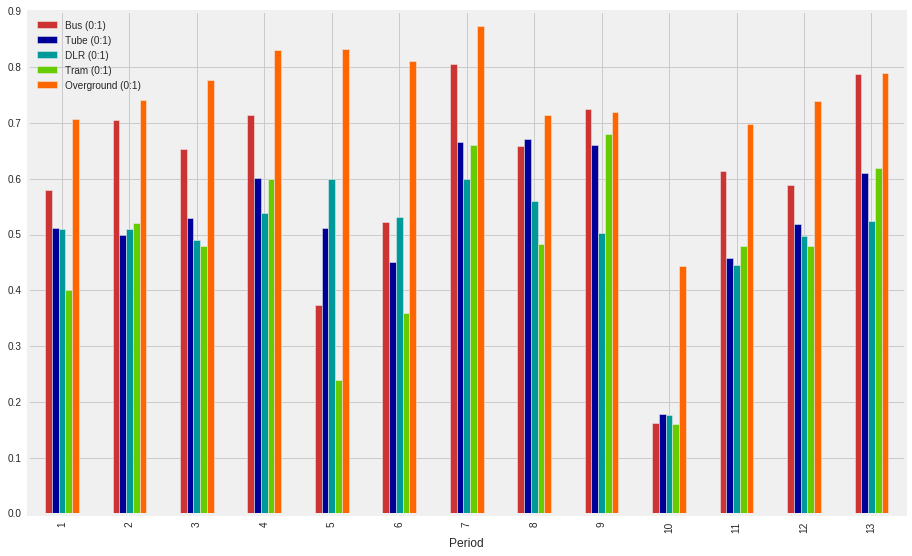

In [144]:
fig, ax = plt.subplots(figsize=(14,9))
periods.mean()[['Bus (0:1)','Tube (0:1)', 'DLR (0:1)', 'Tram (0:1)', 'Overground (0:1)']].plot(kind='bar', color=['#cc3333', '#000099', '#009999', '#66CC00', '#FF6600'], ax=ax)
plt.show()

Looks like period 10 is comparatively busy for the Overground, but less so for other means of transport.

The left skew of the Overground column is also obvious - there are many comparatively large values for it, it is almost the highest in each period, meaning it has lots of busy periods but few quiet ones, whereas the others are more spread out.

What is this mysterious period 10?

In [147]:
df[df['Period'] == 10][['PeriodBeginning', 'PeriodEnding']]

,PeriodBeginning,PeriodEnding
9,12-Dec-10,08-Jan-11
22,11-Dec-11,07-Jan-12
35,09-Dec-12,05-Jan-13
48,08-Dec-13,04-Jan-14
61,07-Dec-14,03-Jan-15
74,07-Dec-15,03-Jan-16


Makes sense - people use public transport less in December, but it's still a relatively busy time for the Overground.